In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

%matplotlib inline

## Load dataset

In [2]:
df_customers = pd.read_csv('data/customers_raw.csv', header=0, index_col='CustomerID')
df_customers.head()

,Age,Education,Income,Occupation,Gender,Marital Status,Settlement Size
CustomerID,,,,,,,
1,67,University,124670,Official,Male,Single,Big City
2,22,High School,150773,Official,Female,Married,Big City
3,49,High School,89210,Unemployed,Male,Single,Small City
4,45,High School,171565,Official,Male,Single,Mid City
5,53,High School,149031,Official,Male,Single,Mid City


## Inspect

In [3]:
print('The dimention of the dataset\n')
print(df_customers.shape)

print('\nDetail description of the dataset\n')
print(df_customers.info())

The dimention of the dataset

(2000, 7)

Detail description of the dataset

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 1 to 2000
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Age              2000 non-null   int64 
 1   Education        2000 non-null   object
 2   Income           2000 non-null   int64 
 3   Occupation       2000 non-null   object
 4   Gender           2000 non-null   object
 5   Marital Status   2000 non-null   object
 6   Settlement Size  2000 non-null   object
dtypes: int64(2), object(5)
memory usage: 125.0+ KB
None


# Feature Engineering

| Feature | Encoding |
| --- | --- |
| Gender | 1: Male, 0: Female |
| Marital Status | 1: Married, 0: Single |
| Education | 0: Unknown, 1: High School, 2: University, 3: Graduate |
| Occupation | 0: Unemployed, 1: Official, 2: Management |
| Settlement Size | 0: Small City, 1: Mid City, 2: Big City |

### Encoding

In [4]:
# encode 'Gender'
df_customers['Gender'] = df_customers['Gender'].replace({'Male':1, 'Female':0})

# encode 'Marital Status'
df_customers['Marital Status'] = df_customers['Marital Status'].map(lambda x: 1 if x=='Married' else 0)

# encode education
education_code = {'Unknown': 0, 'High School': 1, 'University': 2, 'Graduate': 3}
df_customers['Education'] = df_customers['Education'].map(education_code)

# encode occupation
occupation_code = {'Unemployed': 0, 'Official': 1, 'Management': 2}
df_customers['Occupation'] = df_customers['Occupation'].map(occupation_code)

# encode settlement
settlement_code = {'Small City': 0, 'Mid City': 1, 'Big City': 2}
df_customers['Settlement Size'] = df_customers['Settlement Size'].map(settlement_code)

# print dataframe
df_customers.head()

C:\Users\cn4tvne\AppData\Local\Temp\ipykernel_24264\1125734599.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_customers['Gender'] = df_customers['Gender'].replace({'Male':1, 'Female':0})


,Age,Education,Income,Occupation,Gender,Marital Status,Settlement Size
CustomerID,,,,,,,
1,67,2,124670,1,1,0,2
2,22,1,150773,1,0,1,2
3,49,1,89210,0,1,0,0
4,45,1,171565,1,1,0,1
5,53,1,149031,1,1,0,1


### Correlation with heatmap

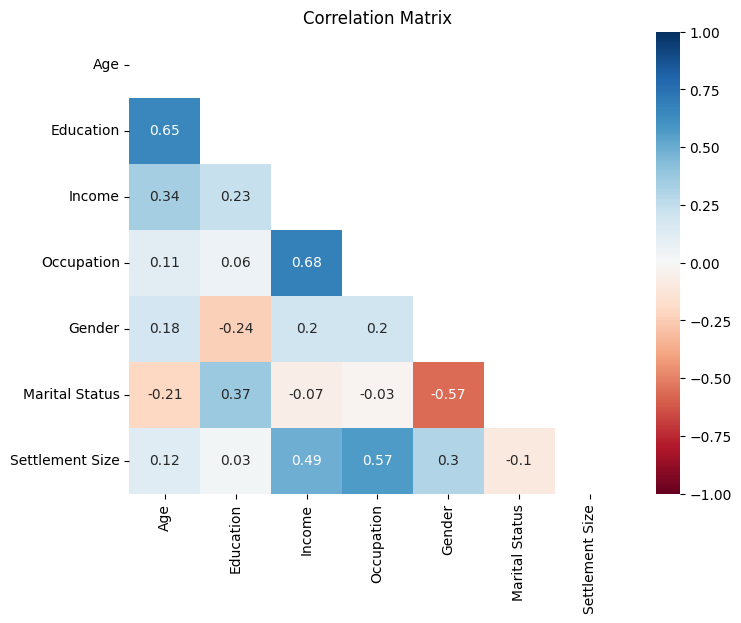

In [5]:
# Compute the correlation matrix
corr_matrix = df_customers.corr().round(2)

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix,
            annot=True,
            cmap='RdBu',
            vmin=-1,
            vmax=1,
            mask=mask)
plt.title('Correlation Matrix')
plt.xticks(rotation=90)
plt.show()

### Standardizing

In [6]:
scaler = StandardScaler()
customers_std = scaler.fit_transform(df_customers)

customers_std[:5]

array([[ 2.65361447,  1.60432297,  0.09752361,  0.29682303,  0.91739884,
        -0.99302433,  1.552326  ],
       [-1.18713209, -0.06337243,  0.78265438,  0.29682303, -1.09003844,
         1.00702467,  1.552326  ],
       [ 1.11731585, -0.06337243, -0.83320224, -1.26952539,  0.91739884,
        -0.99302433, -0.90972951],
       [ 0.77591616, -0.06337243,  1.32838624,  0.29682303,  0.91739884,
        -0.99302433,  0.32129825],
       [ 1.45871554, -0.06337243,  0.73693175,  0.29682303,  0.91739884,
        -0.99302433,  0.32129825]])

In [7]:
df_customers_std = pd.DataFrame(customers_std, columns=df_customers.columns)
df_customers_std.head()

,Age,Education,Income,Occupation,Gender,Marital Status,Settlement Size
0,2.653614,1.604323,0.097524,0.296823,0.917399,-0.993024,1.552326
1,-1.187132,-0.063372,0.782654,0.296823,-1.090038,1.007025,1.552326
2,1.117316,-0.063372,-0.833202,-1.269525,0.917399,-0.993024,-0.909730
3,0.775916,-0.063372,1.328386,0.296823,0.917399,-0.993024,0.321298
4,1.458716,-0.063372,0.736932,0.296823,0.917399,-0.993024,0.321298


### Data Exploration

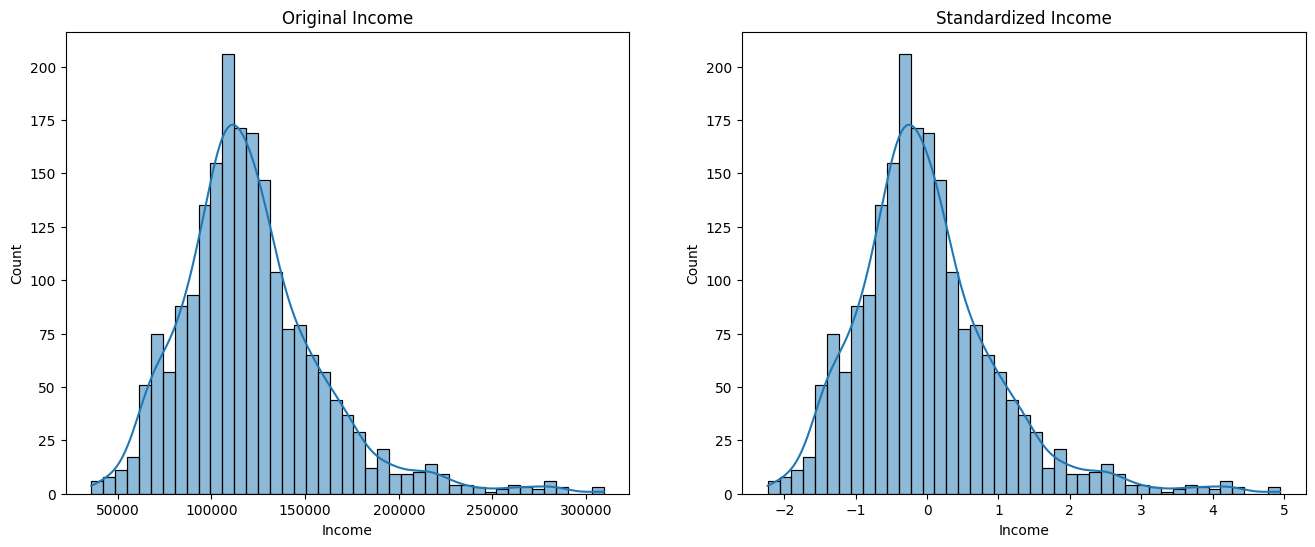

In [8]:
# plt.figure(figsize=(10, 5))
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
sns.histplot(data=df_customers, x='Income', kde=True, ax=ax[0])
ax[0].title.set_text('Original Income')
sns.histplot(data=df_customers_std, x='Income', kde=True, ax=ax[1])
ax[1].title.set_text('Standardized Income')

plt.show()

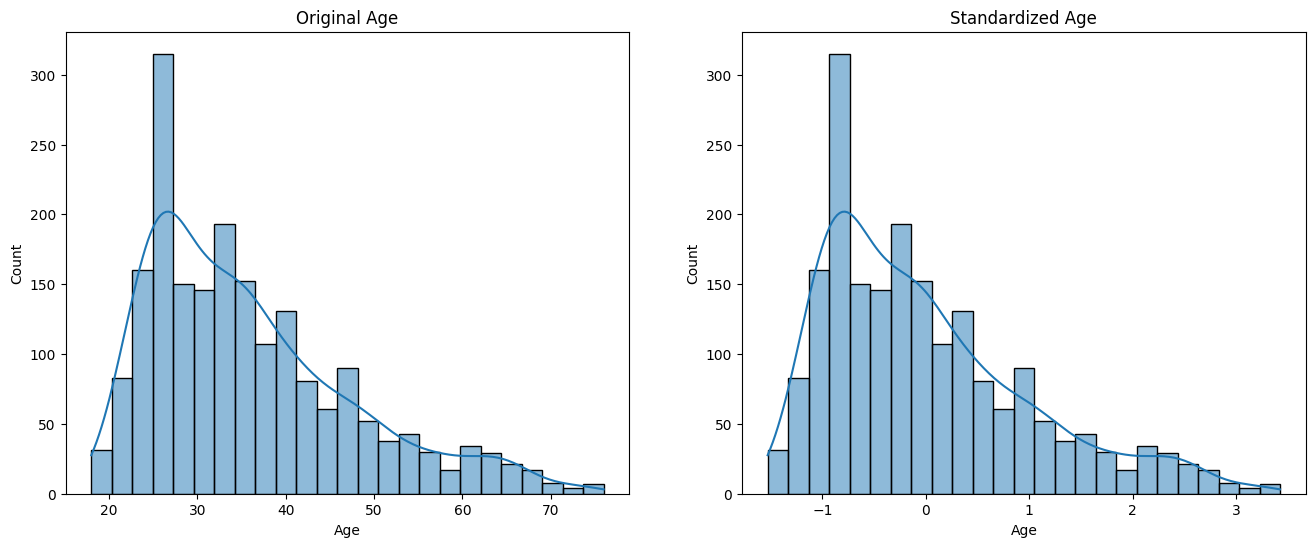

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(data=df_customers, x='Age', kde=True, ax=ax[0])
ax[0].title.set_text('Original Age')
sns.histplot(data=df_customers_std, x='Age', kde=True, ax=ax[1])
ax[1].title.set_text('Standardized Age')

In [10]:
print('Original DF:\t', df_customers_std['Age'].mean(axis=0))
print('Standardized DF:', df_customers['Age'].mean(axis=0))
print('Original DF:\t', df_customers_std['Age'].std(axis=0))
print('Standardized DF:', df_customers['Age'].std(axis=0))

Original DF:	 9.059419880941277e-17
Standardized DF: 35.909
Original DF:	 1.0002500937890797
Standardized DF: 11.719402339522174
